In [1]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensorV2 as ToTensor
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

import random

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
TRAIN_PATH = '../data/stage1_train/'

/home/nakai-yu/dev/imsegnet/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 画像データ拡張の関数
def get_train_transform():
   return A.Compose(
       [
        # リサイズ(こちらはすでに適用済みなのでなくても良いです)
        A.Resize(256, 256),
        # 正規化(こちらの細かい値はalbumentations.augmentations.transforms.Normalizeのデフォルトの値を適用)
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # 水平フリップ（pはフリップする確率）
        A.HorizontalFlip(p=0.25),
        # 垂直フリップ
        A.VerticalFlip(p=0.25),
        ToTensor()
        ])

# Datasetクラスの定義
class LoadDataSet(Dataset):
        def __init__(self, path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()

        def __len__(self):
            return len(self.folders)

        def __getitem__(self, idx):
            image_folder = os.path.join(self.path, self.folders[idx], 'images/')
            mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
            image_path = os.path.join(image_folder, os.listdir(image_folder)[0])

            # 画像データの取得
            img = io.imread(image_path)[:, :, :3].astype('float32')
            img = transform.resize(img, (256, 256))

            mask = self.get_mask(mask_folder, 256, 256).astype('float32')

            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.permute(2, 0, 1)
            return (img, mask) 

        def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder, mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_, axis=-1)
                    mask = np.maximum(mask, mask_)

            return mask

In [3]:
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())

In [4]:
image, mask = train_dataset.__getitem__(0)
print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [5]:
train_dataset.__len__()

670

[617, 177, 442]


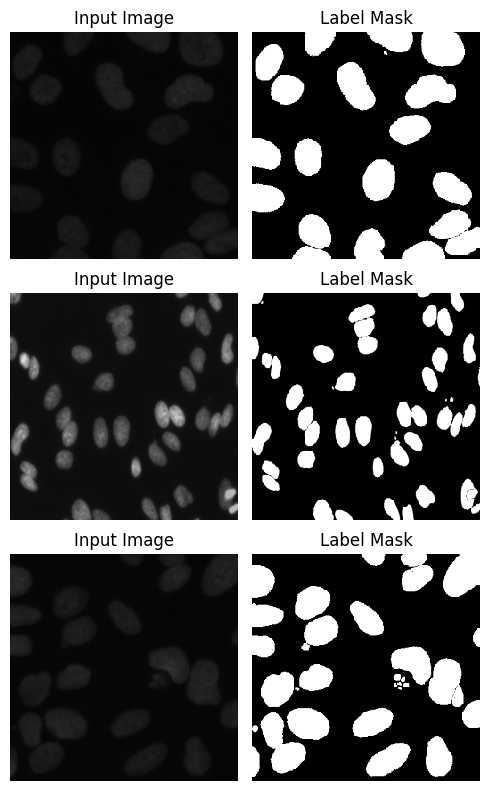

In [6]:
def format_image(img):
    img = np.array(np.transpose(img, (1, 2, 0)))
    # 下は画像拡張での正規化を元に戻しています
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img * 255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1, 2, 0)))
    return mask

def visualize_dataset(n_images, predict=None):
    images = random.sample(range(0, 670), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = train_dataset.__getitem__(img_no)
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title("Input Image")
        ax[i, 1].set_title("Label Mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_dataset(3)

In [7]:
split_ratio = 0.25
train_size=int(np.round(train_dataset.__len__() * (1 - split_ratio), 0))
valid_size=int(np.round(train_dataset.__len__() * split_ratio, 0))
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

print("Length of train data: {}".format(len(train_data)))
print("Length of validation data: {}".format(len(valid_data)))

Length of train data: 502
Length of validation data: 168


In [8]:
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        # 資料中の『FCN』に当たる部分
        self.conv1 = conv_bn_relu(input_channels,64)
        self.conv2 = conv_bn_relu(64, 128)
        self.conv3 = conv_bn_relu(128, 256)
        self.conv4 = conv_bn_relu(256, 512)
        self.conv5 = conv_bn_relu(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # 資料中の『Up Sampling』に当たる部分
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_relu(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_relu(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_relu(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_relu(128, 64)
        self.conv10 = nn.Conv2d(64, output_channels, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # 正規化
        x = x/255.

        # 資料中の『FCN』に当たる部分
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # 資料中の『Up Sampling』に当たる部分, torch.catによりSkip Connectionをしている
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9)
        output = torch.sigmoid(output)

        return output


def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        # 転置畳み込み
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [9]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  

        return 1 - dice

In [10]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

In [11]:
# <---------------各インスタンス作成---------------------->
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = DiceLoss()
accuracy_metric = IoU()
num_epochs=20
valid_loss_min = np.Inf

checkpoint_path = 'model/chkpoint_'
best_model_path = 'model/bestmodel.pt'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(num_epochs):
    # <---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
        x_train = torch.autograd.Variable(x_train).cuda()
        y_train = torch.autograd.Variable(y_train).cuda()
        optimizer.zero_grad()
        output = model(x_train)
        # 損失計算
        loss = criterion(output, y_train)
        losses_value = loss.item()
        # 精度評価
        score = accuracy_metric(output,y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(losses_value)
        train_score.append(score.item())
        pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    # <---------------評価---------------------->
    with torch.no_grad():
        for image,mask in val_loader:
            image = torch.autograd.Variable(image).cuda()
            mask = torch.autograd.Variable(mask).cuda()
            output = model(image)
            # 損失計算
            loss = criterion(output, mask)
            losses_value = loss.item()
            # 精度評価
            score = accuracy_metric(output,mask)
            valid_loss.append(losses_value)
            valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }

    print("")

Epoch: 1, loss: 0.7090675234794617, IoU: 0.1702437549829483: 100%|██████████| 51/51 [02:07<00:00,  2.50s/it]  


Train Loss: 0.3423740185943304, Train IOU: 0.5096741191604558
Valid Loss: 0.2413617162143483, Valid IOU: 0.6284317900152767



Epoch: 2, loss: 0.7649945616722107, IoU: 0.13316503167152405: 100%|██████████| 51/51 [02:07<00:00,  2.49s/it] 


Train Loss: 0.2632950509295744, Train IOU: 0.5954679501991645
Valid Loss: 0.2887712927425609, Valid IOU: 0.5692209285848281



Epoch: 3, loss: 0.16147959232330322, IoU: 0.7219462990760803: 100%|██████████| 51/51 [02:07<00:00,  2.51s/it]


Train Loss: 0.19038353129929186, Train IOU: 0.6862432471677369
Valid Loss: 0.22268752841388478, Valid IOU: 0.6399389119709239



Epoch: 4, loss: 0.11886048316955566, IoU: 0.7875356674194336: 100%|██████████| 51/51 [02:08<00:00,  2.53s/it]


Train Loss: 0.23809989527160047, Train IOU: 0.6238726231397367
Valid Loss: 0.18110113985398235, Valid IOU: 0.7001878864624921



Epoch: 5, loss: 0.05724167823791504, IoU: 0.8917173743247986: 100%|██████████| 51/51 [02:08<00:00,  2.52s/it]


Train Loss: 0.21781516308877982, Train IOU: 0.6506401960756264
Valid Loss: 0.20018495882258697, Valid IOU: 0.6713323242524091



Epoch: 6, loss: 0.26715391874313354, IoU: 0.5783523321151733: 100%|██████████| 51/51 [02:08<00:00,  2.53s/it]


Train Loss: 0.19122175843107933, Train IOU: 0.6835432268825232
Valid Loss: 0.1731501817703247, Valid IOU: 0.7084082680590013



Epoch: 7, loss: 0.13390904664993286, IoU: 0.7638132572174072: 100%|██████████| 51/51 [02:08<00:00,  2.52s/it]


Train Loss: 0.16082841391656913, Train IOU: 0.7258242719313678
Valid Loss: 0.13619484620935776, Valid IOU: 0.7627874086884892



Epoch: 8, loss: 0.08337956666946411, IoU: 0.8460784554481506: 100%|██████████| 51/51 [02:07<00:00,  2.50s/it]


Train Loss: 0.1449364786054574, Train IOU: 0.7511975923005272
Valid Loss: 0.12986685949213364, Valid IOU: 0.771816818153157



Epoch: 9, loss: 0.8245972394943237, IoU: 0.09615760296583176: 100%|██████████| 51/51 [02:07<00:00,  2.50s/it]


Train Loss: 0.15487959922528735, Train IOU: 0.7423026548588977
Valid Loss: 0.17182019878836238, Valid IOU: 0.7126463599064771



Epoch: 10, loss: 0.15563815832138062, IoU: 0.7306502461433411: 100%|██████████| 51/51 [02:08<00:00,  2.51s/it]


Train Loss: 0.1640754458951015, Train IOU: 0.7222342099629196
Valid Loss: 0.18535892051808975, Valid IOU: 0.6896264763439403



Epoch: 11, loss: 0.2508212924003601, IoU: 0.5989586710929871: 100%|██████████| 51/51 [02:07<00:00,  2.50s/it] 


Train Loss: 0.17462051382251814, Train IOU: 0.7068053781986237
Valid Loss: 0.16104947819429286, Valid IOU: 0.7249005822574391



Epoch: 12, loss: 0.07555270195007324, IoU: 0.8595137000083923: 100%|██████████| 51/51 [02:08<00:00,  2.53s/it]


Train Loss: 0.16862639726377002, Train IOU: 0.7140325518215404
Valid Loss: 0.13969922416350422, Valid IOU: 0.7560831413549536



Epoch: 13, loss: 0.791590690612793, IoU: 0.11635350435972214: 100%|██████████| 51/51 [02:09<00:00,  2.53s/it] 


Train Loss: 0.1481432599179885, Train IOU: 0.7501045043269793
Valid Loss: 0.15755759267246022, Valid IOU: 0.7317312044255874



Epoch: 14, loss: 0.28072601556777954, IoU: 0.5616202354431152: 100%|██████████| 51/51 [02:09<00:00,  2.53s/it]


Train Loss: 0.1609860378153184, Train IOU: 0.7266992014997146
Valid Loss: 0.16904962062835693, Valid IOU: 0.7125822130371543



Epoch: 15, loss: 0.11058050394058228, IoU: 0.8008629083633423: 100%|██████████| 51/51 [02:09<00:00,  2.53s/it]


Train Loss: 0.14483712584364647, Train IOU: 0.7492073669153101
Valid Loss: 0.13453851377262788, Valid IOU: 0.7656610012054443



Epoch: 16, loss: 0.2495899200439453, IoU: 0.6005316376686096: 100%|██████████| 51/51 [02:09<00:00,  2.53s/it]  


Train Loss: 0.14387961111816705, Train IOU: 0.7529185396783492
Valid Loss: 0.19562939335318172, Valid IOU: 0.6825321053757387



Epoch: 17, loss: 0.07700598239898682, IoU: 0.8570029735565186: 100%|██████████| 51/51 [02:08<00:00,  2.53s/it]


Train Loss: 0.14111806364620433, Train IOU: 0.7550820252474617
Valid Loss: 0.12577923606423771, Valid IOU: 0.7780259742456324



Epoch: 18, loss: 0.3311358690261841, IoU: 0.5025020241737366: 100%|██████████| 51/51 [02:07<00:00,  2.51s/it] 


Train Loss: 0.12919552770315432, Train IOU: 0.7739329197827507
Valid Loss: 0.11346064595615163, Valid IOU: 0.7974665270132177



Epoch: 19, loss: 0.15761172771453857, IoU: 0.7277037501335144: 100%|██████████| 51/51 [02:08<00:00,  2.51s/it]


Train Loss: 0.13241996601516126, Train IOU: 0.7691809348031586
Valid Loss: 0.15157154027153463, Valid IOU: 0.7388332696521983



Epoch: 20, loss: 0.142316997051239, IoU: 0.7508455514907837: 100%|██████████| 51/51 [02:09<00:00,  2.54s/it]  


Train Loss: 0.11899931991801542, Train IOU: 0.7885728992667853
Valid Loss: 0.11252748264985926, Valid IOU: 0.7991441944066215



<Figure size 640x480 with 0 Axes>

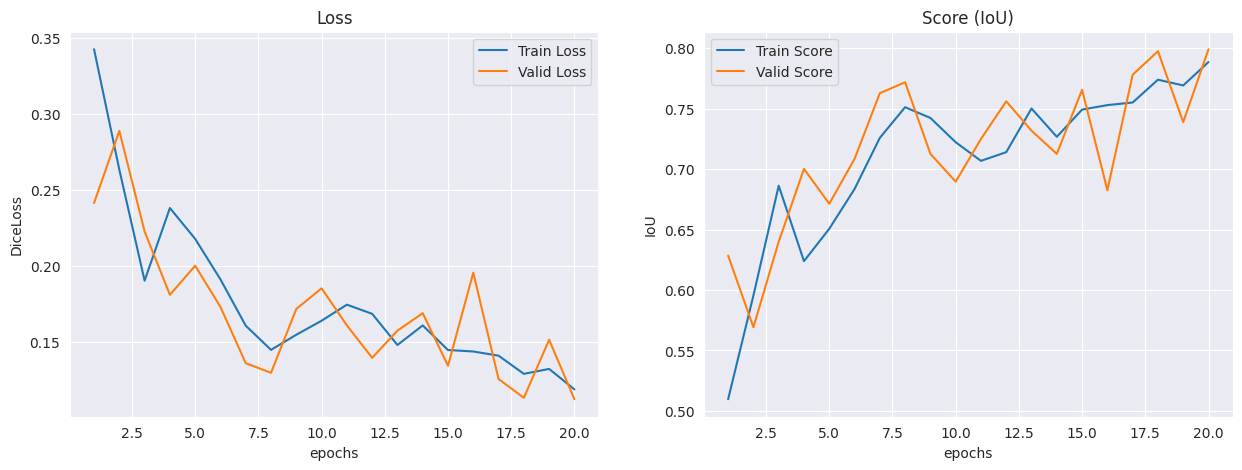

In [12]:
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15,5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1,num_epochs+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,num_epochs+1), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1,num_epochs+1), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,num_epochs+1), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("epochs")
plt.ylabel("IoU")
plt.show()

/tmp/ipykernel_370146/108397165.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = torch.autograd.Variable(data, volatile=True).cuda()
/tmp/ipykernel_370146/108397165.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  mask = torch.autograd.Variable(mask, volatile=True).cuda()


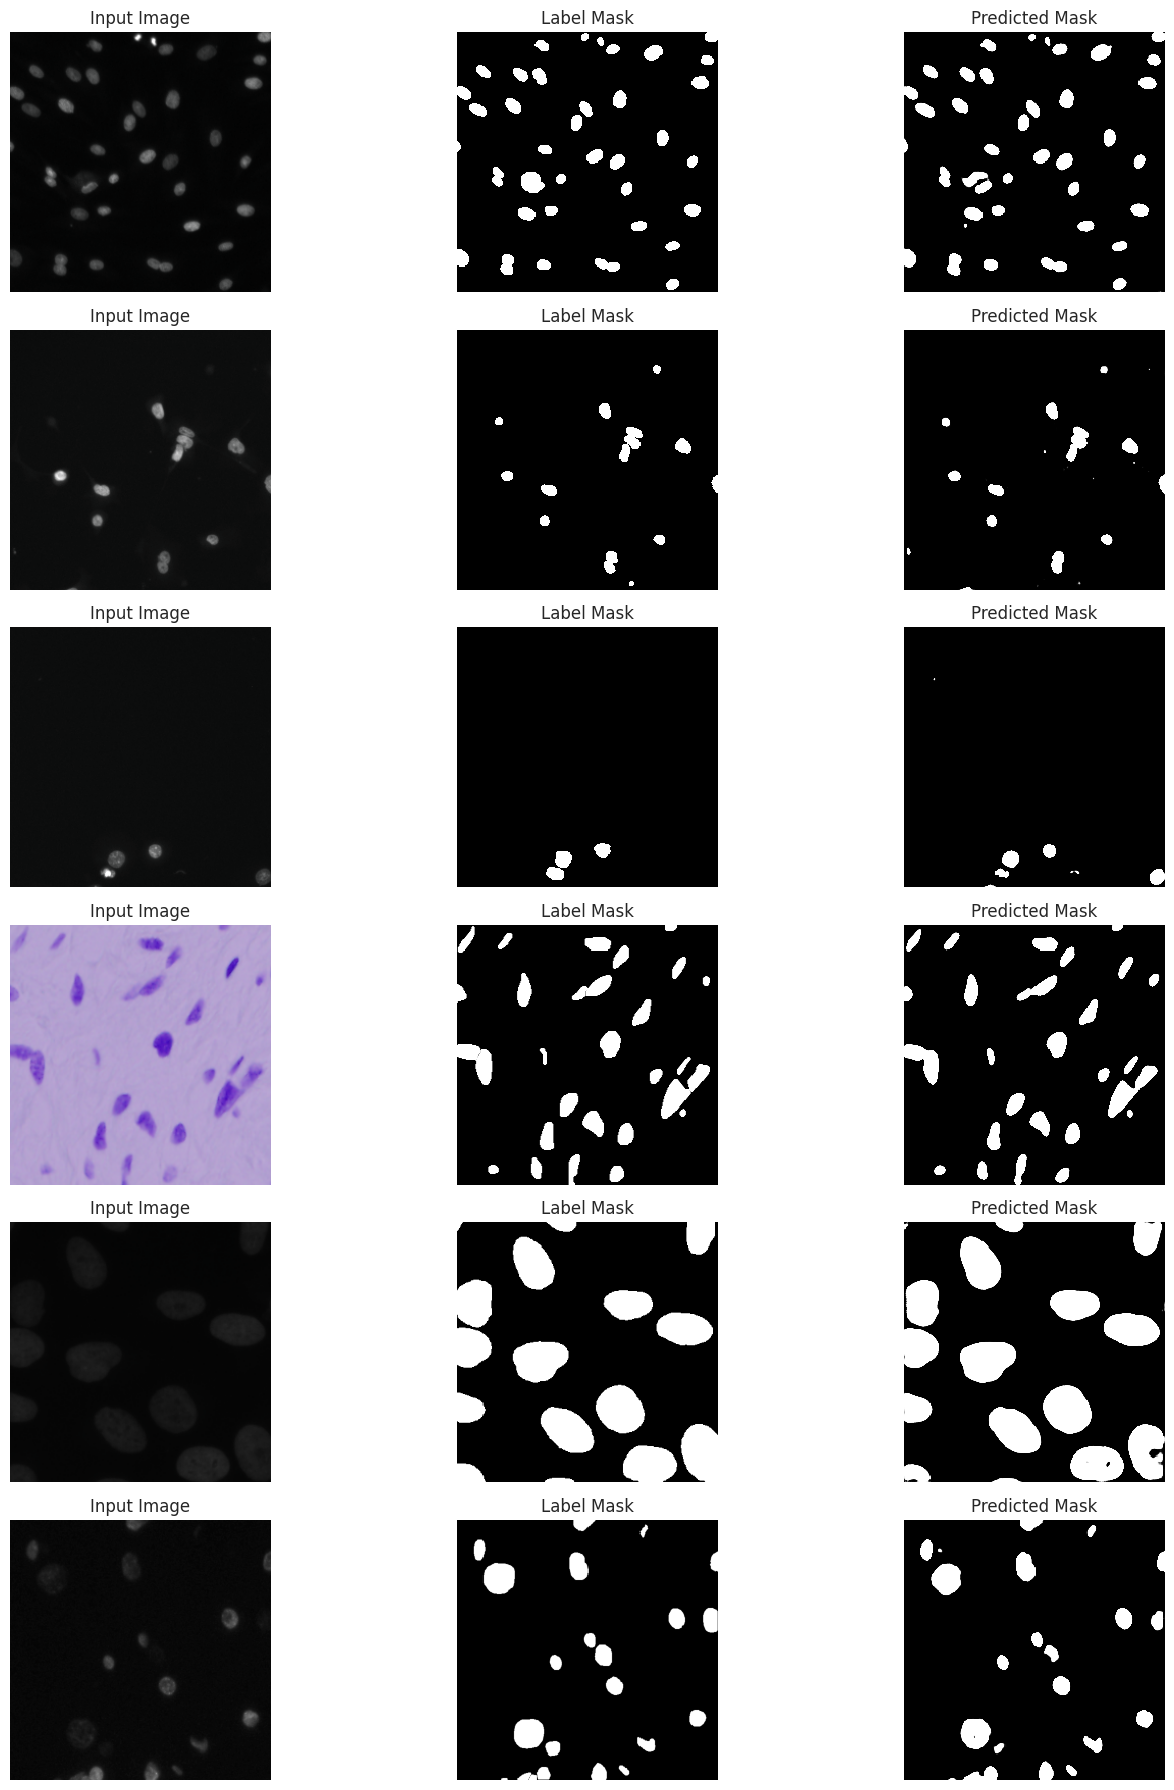

In [13]:
def visualize_predict(model, n_images):
    figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
    with torch.no_grad():
        for data,mask in val_loader:
            data = torch.autograd.Variable(data, volatile=True).cuda()
            mask = torch.autograd.Variable(mask, volatile=True).cuda()
            o = model(data)
            break
    for img_no in range(0, n_images):
        tm=o[img_no][0].data.cpu().numpy()
        img = data[img_no].data.cpu()
        msk = mask[img_no].data.cpu()
        img = format_image(img)
        msk = format_mask(msk)
        ax[img_no, 0].imshow(img)
        ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
        ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
        ax[img_no, 0].set_title("Input Image")
        ax[img_no, 1].set_title("Label Mask")
        ax[img_no, 2].set_title("Predicted Mask")
        ax[img_no, 0].set_axis_off()
        ax[img_no, 1].set_axis_off()
        ax[img_no, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_predict(model, 6)